In [5]:
# Suppression des avertissements et configuration
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Librairies de base
import numpy as np
import pandas as pd
from tqdm import tqdm
from textwrap import wrap

# Visualisation
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
import seaborn as sns
sns.set_style("dark")

# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Input, Embedding, LSTM, Dropout,
    Reshape, concatenate, add
)
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau
)

# Sérialisation
import pickle

In [6]:
image_path = 'flickr8k/Images'
data = pd.read_csv("flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

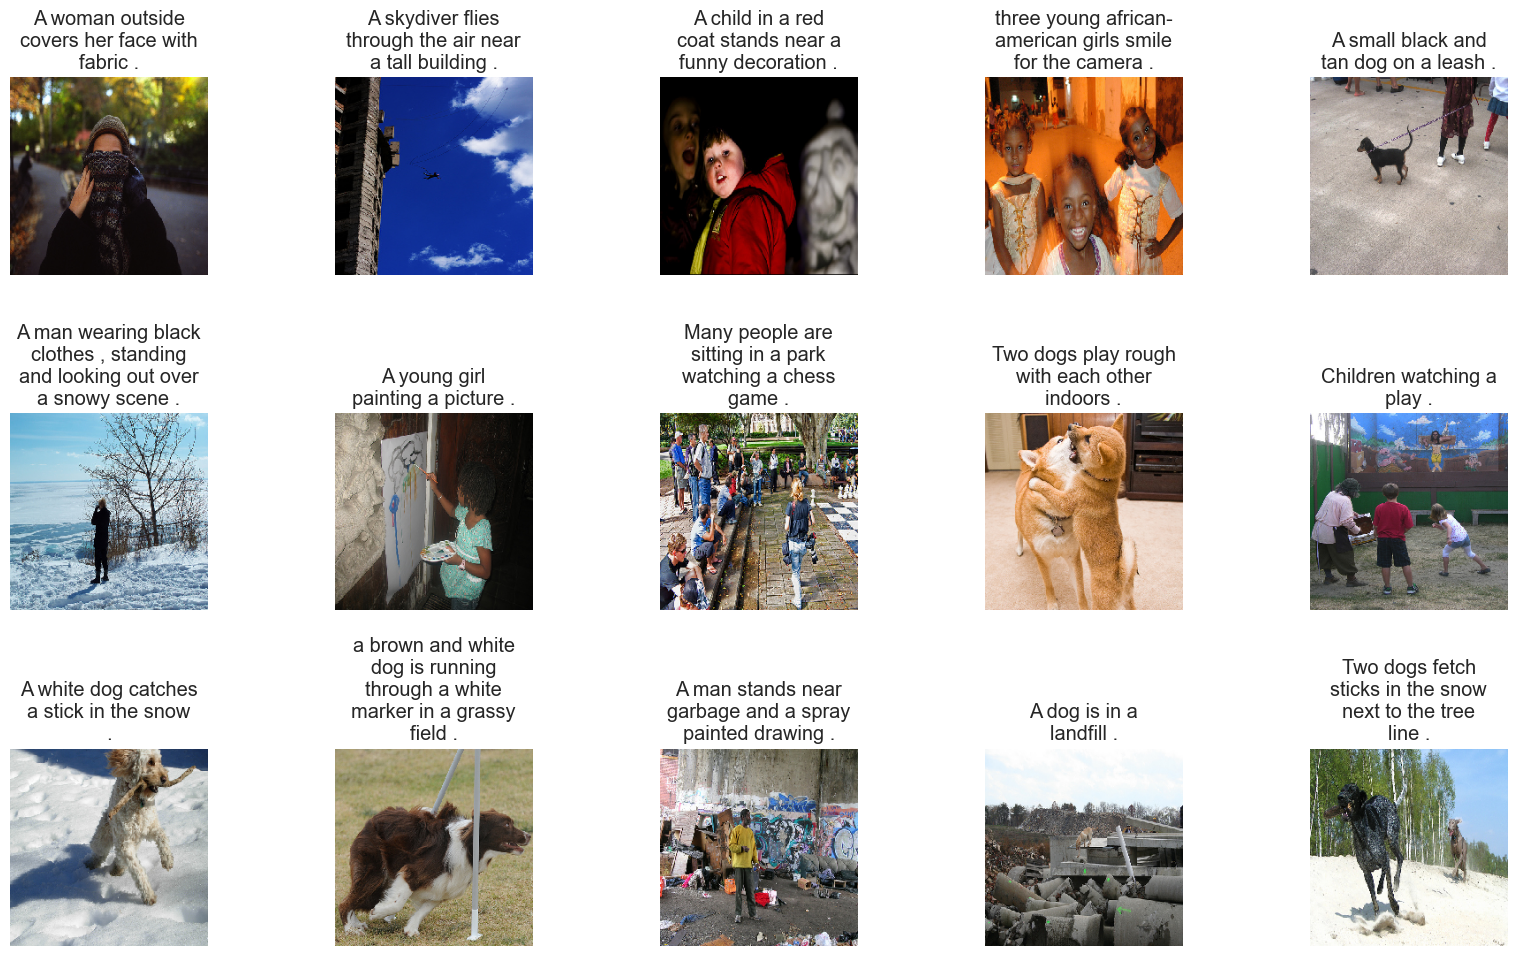

In [8]:
display_images(data.sample(15))

In [9]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [10]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Sauvegarder le tokenizer et max_length
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump({'tokenizer': tokenizer, 'max_length': max_length}, f)


images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [30]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

  0%|          | 10/8091 [00:08<1:56:30,  1.16it/s]

KeyboardInterrupt



In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "caption_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction],
        verbose=0)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

In [ ]:
display_images(samples)

In [15]:
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet201

class ImageCaptionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Générateur de descriptions d'images")

        # Chargement du modèle et du tokenizer
        print("Chargement du modèle...")
        self.caption_model = tf.keras.models.load_model('caption_model.keras')
        print("Chargement du tokenizer...")
        # Chargement du tokenizer et de max_length
        with open('tokenizer.pkl', 'rb') as f:
            data = pickle.load(f)
            self.tokenizer = data['tokenizer']
            self.max_length = data['max_length']


        # Configuration du modèle DenseNet pour l'extraction des caractéristiques
        model = DenseNet201()
        self.feature_extractor = tf.keras.Model(inputs=model.input,
                                              outputs=model.layers[-2].output)

        print(f"Longueur maximale de séquence: {self.max_length}")

        self.setup_gui()

    def setup_gui(self):
        # Frame principale
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        # Bouton pour charger l'image
        self.load_btn = ttk.Button(main_frame,
                                   text="Charger une image",
                                   command=self.load_image)
        self.load_btn.grid(row=0, column=0, pady=10)

        # Zone d'affichage de l'image
        self.image_label = ttk.Label(main_frame)
        self.image_label.grid(row=1, column=0, pady=10)

        # Zone de texte pour la description
        self.description_var = tk.StringVar()
        self.description_label = ttk.Label(main_frame,
                                           textvariable=self.description_var,
                                           wraplength=400)
        self.description_label.grid(row=2, column=0, pady=10)


    def load_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Images", "*.jpg *.jpeg *.png *.bmp *.gif *.tiff")]
        )

        if file_path:
            # Charger et redimensionner l'image pour l'affichage
            self.current_image_path = file_path
            image = Image.open(file_path)
            image = image.resize((224, 224))
            self.photo = ImageTk.PhotoImage(image)  # Maintenir une référence persistante

            self.image_label.configure(image=self.photo)
            self.image_label.image = self.photo  # Éviter la collecte par le garbage collector

            self.description_var.set("Génération de la description en cours...")
            self.root.update()  # Mettre à jour l'interface utilisateur

            # Appeler automatiquement la génération de la description
            self.generate_caption()

    def extract_features(self, image_path):
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img/255.
        img = np.expand_dims(img, axis=0)
        feature = self.feature_extractor.predict(img, verbose=0)
        return feature

    def idx_to_word(self, integer):
        for word, index in self.tokenizer.word_index.items():
            if index == integer:
                return word
        return None

    def predict_caption(self, image_path):
        feature = self.extract_features(image_path)
        in_text = "startseq"

        for i in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)

            try:
                y_pred = self.caption_model.predict([feature, sequence], verbose=0)
                y_pred = np.argmax(y_pred)

                word = self.idx_to_word(y_pred)

                if word is None:
                    break

                in_text += " " + word

                if word == 'endseq':
                    break
            except Exception as e:
                print(f"Erreur lors de la prédiction: {str(e)}")
                print(f"Shape de sequence: {sequence.shape}")
                print(f"Shape de feature: {feature.shape}")
                raise e

        return in_text

    def generate_caption(self):
        if hasattr(self, 'current_image_path'):
            self.description_var.set("Génération de la description en cours...")
            self.root.update()

            try:
                caption = self.predict_caption(self.current_image_path)
                # Nettoyer la description
                caption = caption.replace('startseq', '').replace('endseq', '').strip()

                self.description_var.set(caption)
            except Exception as e:
                self.description_var.set(f"Erreur lors de la génération: {str(e)}")


if __name__ == "__main__":
    root = tk.Tk()
    app = ImageCaptionApp(root)
    root.mainloop()

Chargement du modèle...
Chargement du tokenizer...
Longueur maximale de séquence: 34
